# Imports

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.utils import plot_model, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd

# Data Preprocessing

In [5]:
# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define the dataset directory - this was ran on Kaggle Notebook. Should be changed to appropriate local directory
dataset_directory = '/kaggle/input/fer2013'
train_dir = f'/kaggle/input/fer2013/train'
test_dir = f'/kaggle/input/fer2013/test'

In [7]:
data_gen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1] by scaling by 255
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,  # Apply a shear transformation with a range of 20 degrees
    zoom_range=0.2,  # Randomly zoom in or out by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    validation_split=0.2  # Reserve 20% of the data for validation
)

def get_generators(target_size):
    train_gen = data_gen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )
    val_gen = data_gen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )
    test_gen = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=32,
        class_mode='categorical'
    )
    return train_gen, val_gen, test_gen

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


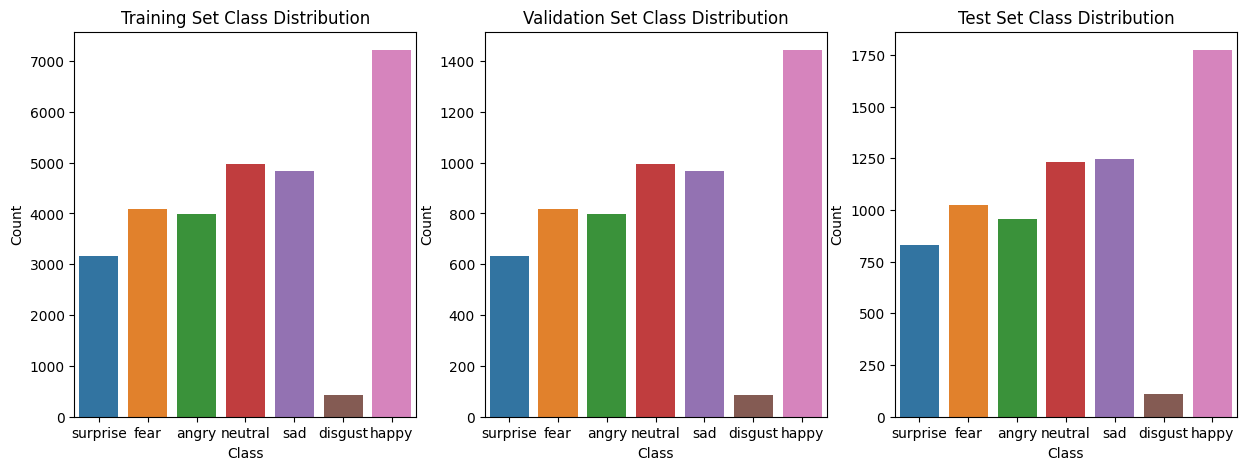

In [8]:
# Function to count images in each class
def count_images_in_directory(directory):
    class_counts = {}
    # Iterate over class directories and count images
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            # Count the number of files in each class directory
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Get class counts for training, validation, and test datasets
train_class_counts = count_images_in_directory(train_dir)

# Calculate the validation set class counts based on the split
validation_split = 0.2
val_class_counts = {key: int(value * validation_split) for key, value in train_class_counts.items()}

# Get test set class counts
test_class_counts = count_images_in_directory(test_dir)

# Plot class distribution for training, validation, and test datasets
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(x=list(train_class_counts.keys()), y=list(train_class_counts.values()), ax=axes[0])
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

sns.barplot(x=list(val_class_counts.keys()), y=list(val_class_counts.values()), ax=axes[1])
axes[1].set_title('Validation Set Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

sns.barplot(x=list(test_class_counts.keys()), y=list(test_class_counts.values()), ax=axes[2])
axes[2].set_title('Test Set Class Distribution')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Count')

plt.show()

# Model Training

In [9]:
# Function to create a custom model
def create_model(base_model, num_classes):
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Set the correct number of classes
    return Model(inputs=base_model.input, outputs=outputs)

In [10]:
# Define callbacks for early stopping and learning rate reduction
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5, verbose=1)
]

# Define a function to train, evaluate, and plot model metrics
def train_and_evaluate(model, train_gen, val_gen, test_gen, epochs=5):
    #Display the model summary
    model.summary()
    
    # Train the model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks
    )

    # Evaluate on the test set and calculate additional metrics
    test_loss, test_acc = model.evaluate(test_gen)
    
    # Get predictions and ground truth labels from the test set
    predictions = model.predict(test_gen)
    predicted_classes = np.argmax(predictions, axis=1)  # Get class with highest probability
    true_classes = test_gen.classes
    
    # Calculate precision, recall, and F1-score
    precision = precision_score(true_classes, predicted_classes, average='macro')
    recall = recall_score(true_classes, predicted_classes, average='macro')
    f1 = f1_score(true_classes, predicted_classes, average='macro')

    # Print precision, recall, and F1 score
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    # Plot training and validation accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model.name} - Training and Validation Accuracy')
    plt.legend()
    plt.show()
    
    # Plot loss and validation loss
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model.name} - Training and Validation Loss')
    plt.legend()
    plt.show()

    # Save the model
    model.save(f'{model.name}_model.h5')
    print("Model saved as:", f'{model.name}_model.h5')

    return history, test_loss, test_acc, precision, recall, f1

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,360,967 (12.82 MB)

 Trainable params: 3,339,079 (12.74 MB)

 Non-trainable params: 21,888 (85.50 KB)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/718 ━━━━━━━━━━━━━━━━━━━━ 8:17:31 42s/step - accuracy: 0.1250 - loss: 4.1364

I0000 00:00:1717310632.448896     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717310632.493334     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


641/718 ━━━━━━━━━━━━━━━━━━━━ 43s 559ms/step - accuracy: 0.2341 - loss: 2.3378

W0000 00:00:1717310989.989737     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.2398 - loss: 2.2955

W0000 00:00:1717311031.222418     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


718/718 ━━━━━━━━━━━━━━━━━━━━ 539s 694ms/step - accuracy: 0.2398 - loss: 2.2950 - val_accuracy: 0.4457 - val_loss: 1.4909 - learning_rate: 1.0000e-04
Epoch 2/5


W0000 00:00:1717311130.039388     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


718/718 ━━━━━━━━━━━━━━━━━━━━ 347s 479ms/step - accuracy: 0.4080 - loss: 1.5304 - val_accuracy: 0.5041 - val_loss: 1.3054 - learning_rate: 1.0000e-04
Epoch 3/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 318s 439ms/step - accuracy: 0.4866 - loss: 1.3375 - val_accuracy: 0.5513 - val_loss: 1.2105 - learning_rate: 1.0000e-04
Epoch 4/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 318s 439ms/step - accuracy: 0.5263 - loss: 1.2668 - val_accuracy: 0.5732 - val_loss: 1.1358 - learning_rate: 1.0000e-04
Epoch 5/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 327s 452ms/step - accuracy: 0.5607 - loss: 1.1829 - val_accuracy: 0.5867 - val_loss: 1.0989 - learning_rate: 1.0000e-04
225/225 ━━━━━━━━━━━━━━━━━━━━ 60s 268ms/step - accuracy: 0.5939 - loss: 1.0816


W0000 00:00:1717312500.481589     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  5/225 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step

W0000 00:00:1717312502.397023     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step


W0000 00:00:1717312515.061030     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.1356886008506111
Recall: 0.13814171604267003
F1 Score: 0.1310866482189191


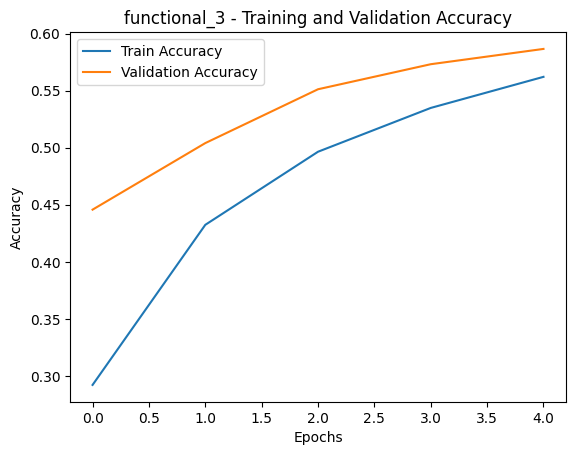

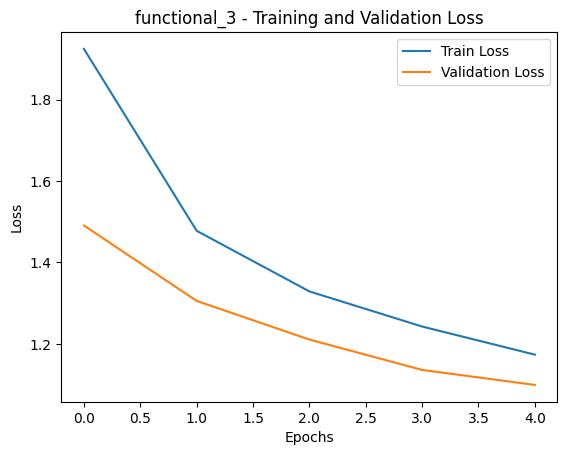

Model saved as: functional_3_model.h5


In [12]:
mobilenet_model = create_model(MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), 7)
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

train_gen, val_gen, test_gen = get_generators((224, 224))
mobilenet_history, mobilenet_test_loss, mobilenet_test_acc, mobilenet_precision, mobilenet_recall, mobilenet_f1 = train_and_evaluate(mobilenet_model, train_gen, val_gen, test_gen)

In [14]:
mobilenet_model.save('mobilenet.h5')